In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import waterfall_chart
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [3]:
# ------------------------------
# 1. Load and preprocess dataset
# ------------------------------
df = pd.read_csv("../datasets/loan_predication/loan_predication.csv")
df = df.drop(columns=['Loan_ID'])
display(df.head(1))
le = LabelEncoder()
y = le.fit_transform(df['Loan_Status'])
X = df.drop(columns=['Loan_Status'])

for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))

X = X.fillna(X.median(numeric_only=True))
X = X.fillna(X.mode().iloc[0])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

train_df = X_train.copy()
train_df['Loan_Status'] = y_train
test_df = X_test.copy()
test_df['Loan_Status'] = y_test

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y


In [8]:
privileged_groups = [{'Gender':1}]
unprivileged_groups = [{'Gender':0}]

dataset_train = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=train_df,
    label_names=['Loan_Status'],
    protected_attribute_names=['Gender']
)

dataset_test = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=test_df,
    label_names=['Loan_Status'],
    protected_attribute_names=['Gender']
)

In [10]:
# Dataset fairness
dataset_metric = BinaryLabelDatasetMetric(
    dataset_train,
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups
)

dataset_fairness = {
    'Disparate Impact Ratio (data)': dataset_metric.disparate_impact(),
    'Statistical Parity Difference (data)':dataset_metric.statistical_parity_difference()
}

print('\n=== Dataset Fairness ===')
print('For disparate impact ratio, its prob1/prob2, value should be close to 1, with 80% rule, values <0.8 or >1.25 is bad also')
print('For Parity difference, its Prob of class 1-class0, so value near to zero is good')
      
pd.Series(dataset_fairness).round(4)


=== Dataset Fairness ===
For disparate impact ratio, its prob1/prob2, value should be close to 1, with 80% rule, values <0.8 or >1.25 is bad also
For Parity difference, its Prob of class 1-class0, so value near to zero is good


Disparate Impact Ratio (data)           1.0152
Statistical Parity Difference (data)    0.0107
dtype: float64

In [13]:
# ------------------------------
# 3. Helper function
# ------------------------------
def evaluate_model(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:,1] if hasattr(clf, "predict_proba") else None

    # Performance metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    auc  = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    # Fairnss Metrics
    dataset_pred = dataset_test.copy()
    dataset_pred.labels = y_pred.reshape(-1,1)
    metric = ClassificationMetric(
        dataset_test,dataset_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )

    fairness = {
        'Disparate Impact Ratio':metric.disparate_impact(),
        'Statistical Parity Difference':metric.statistical_parity_difference(),
        'Average Odd Difference':metric.average_odds_difference(),
        'Equal Opportunity Difference':metric.equal_opportunity_difference(),
        'False Positive Rate Difference':metric.false_positive_rate_difference(),
        'False Negative Rate Differece':metric.false_negative_rate_difference(),
        'Theil Index':metric.theil_index()
    }

    return {'Accuracy':acc,'Precision':prec,'Recall':rec,'F1':f1,'AUC':auc}, fairness

In [14]:
# Evaluate models
models = {
    'Logistic Regression': LogisticRegression(max_iter=500,random_state=42),
    'Decision Tree':DecisionTreeClassifier(max_depth=5,random_state=42),
    'Random Forest':RandomForestClassifier(n_estimators=50,random_state=42)
}

performance_results = {}
fairness_results = {}

for name,clf in models.items():
    perf, fair = evaluate_model(clf,X_train,y_train,X_test,y_test)
    performance_results[name] = perf
    fairness_results[name] = fair

perf_df = pd.DataFrame(performance_results).T
fair_df = pd.DataFrame(fairness_results).T

print('\n=== Model Performance ===')
display(perf_df.round(4))

print('\n=== Model Fairness ===')
display(fair_df.round(4))


=== Model Performance ===


,Accuracy,Precision,Recall,F1,AUC
Logistic Regression,0.7838,0.7564,0.9833,0.8551,0.7826
Decision Tree,0.7514,0.7403,0.9500,0.8321,0.6502
Random Forest,0.7784,0.7762,0.9250,0.8441,0.7771



=== Model Fairness ===


,Disparate Impact Ratio,Statistical Parity Difference,Average Odd Difference,Equal Opportunity Difference,False Positive Rate Difference,False Negative Rate Differece,Theil Index
Logistic Regression,0.9646,-0.0302,0.0232,0.0192,0.0271,-0.0192,0.0606
Decision Tree,0.9297,-0.0594,-0.0255,0.0577,-0.1086,-0.0577,0.0845
Random Forest,0.8551,-0.1150,-0.0673,0.0103,-0.1448,-0.0103,0.0961


# Visualize on fairness

<Figure size 1000x500 with 0 Axes>

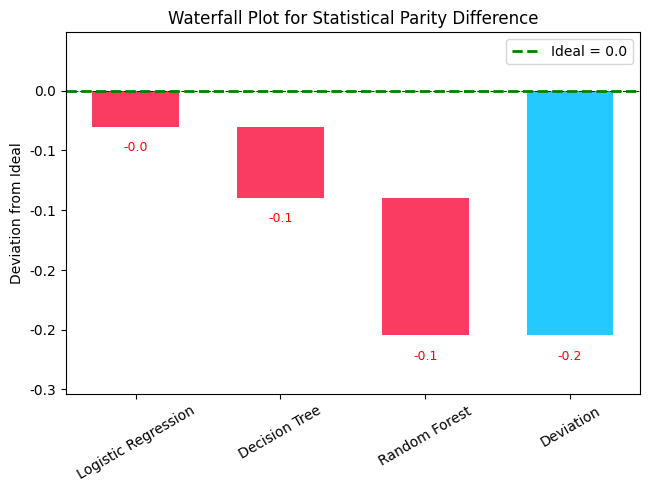

<Figure size 1000x500 with 0 Axes>

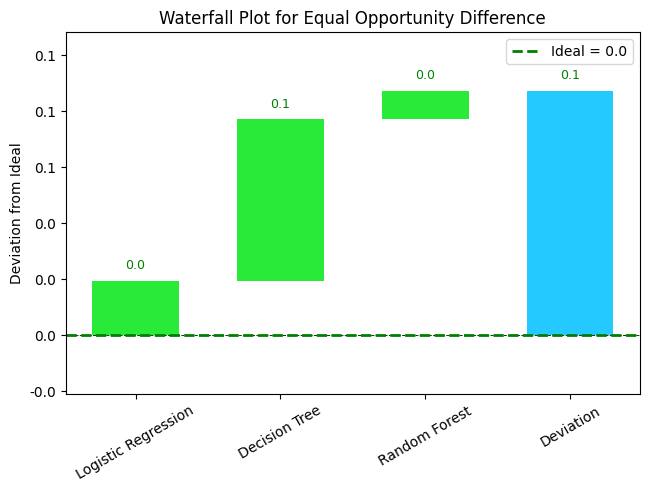

<Figure size 1000x500 with 0 Axes>

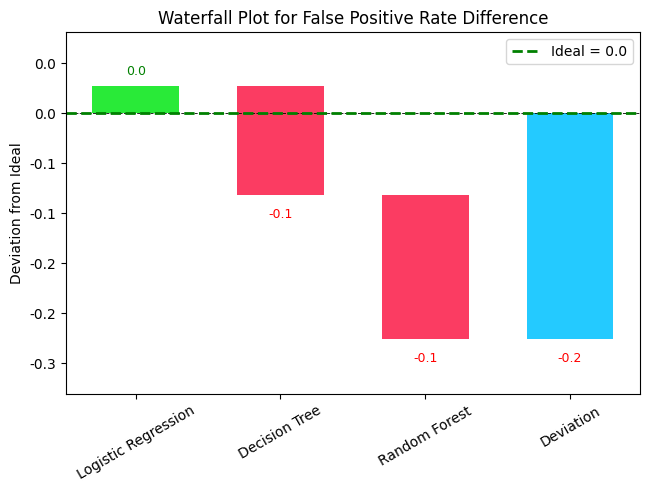

<Figure size 1000x500 with 0 Axes>

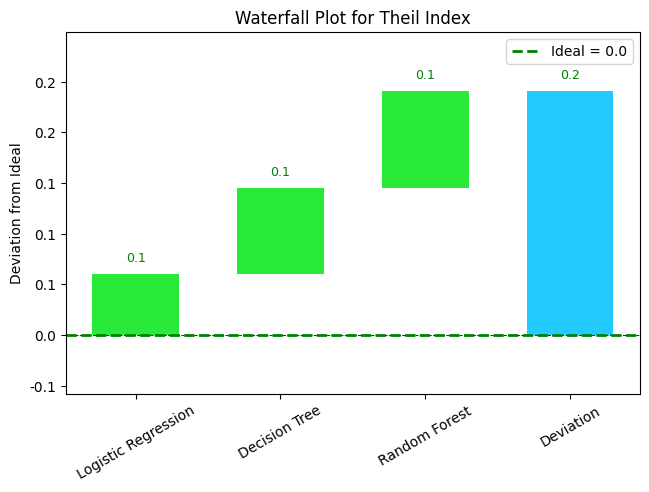

In [15]:
# 5. Visualization (waterfall plots for fairness)

ideal_values = {
    "Disparate Impact": 1.0,
    "Statistical Parity Difference": 0.0,
    "Average Odds Difference": 0.0,
    "Equal Opportunity Difference": 0.0,
    "False Positive Rate Difference": 0.0,
    "False Negative Rate Difference": 0.0,
    "Theil Index": 0.0  
}

for metric,ideal in ideal_values.items():
    if metric not in fair_df.columns:
        continue

    vals = fair_df[metric]
    labels = list(fair_df.index)
    values = list(vals - ideal)

    plt.figure(figsize=(10,5))
    waterfall_chart.plot(labels,values,threshold=None,net_label='Deviation')
    plt.axhline(0,color='green',linestyle='--', linewidth=2,label=f'Ideal = {ideal}')
    plt.title(f'Waterfall Plot for {metric}')
    plt.ylabel('Deviation from Ideal')
    plt.legend()
    plt.show()